# PyPortfolioOpt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### データ取得

In [2]:
import datetime
import yfinance as yf

In [3]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ"]
start_date = datetime.datetime(2012, 4, 1)
end_date = datetime.datetime(2022, 3, 31)

In [4]:
df_ohlc = yf.download(tickers, period="max")
df_prices = df_ohlc["Adj Close"]
df = df_prices.loc[start_date:end_date]
df.tail()

[*********************100%***********************]  5 of 5 completed


,AMZN,BAC,DPZ,MSFT,NAT
Date,,,,,
2022-03-25,164.773499,43.479568,393.599213,302.974335,1.871827
2022-03-28,168.990494,43.300598,397.916718,309.978058,1.782692
2022-03-29,169.315002,43.191227,410.819336,314.677094,1.832212
2022-03-30,166.300995,42.753750,405.095886,313.130676,2.030288
2022-03-31,162.997498,40.983944,405.833771,307.593567,2.109519


### リターンとリスク

https://qiita.com/well_living/items/c2445a5705b495002c1d

In [5]:
import pypfopt as pfo

In [6]:
# リターンの平均
pfo.expected_returns.mean_historical_return(
    df,
    returns_data=False,  # リターン or 株価
    compounding=True,  # 幾何平均 or 算術平均
    frequency=252,
    log_returns=False
)

AMZN    0.323845
BAC     0.173477
DPZ     0.283813
MSFT    0.279823
NAT    -0.120900
dtype: float64

In [7]:
# リターンの指数荷重平均
pfo.expected_returns.ema_historical_return(
    df,
    returns_data=False,  # リターン or 株価
    compounding=True,  # 幾何平均 or 算術平均
    span=500,
    frequency=252,
    log_returns=False
)

AMZN    0.170319
BAC     0.203152
DPZ     0.046363
MSFT    0.325662
NAT     0.075016
Name: 2022-03-31 00:00:00, dtype: float64

In [8]:
# 標本分散共分散行列
pfo.risk_models.sample_cov(df, frequency=252)

,AMZN,BAC,DPZ,MSFT,NAT
AMZN,0.094376,0.028014,0.026352,0.043807,0.030108
BAC,0.028014,0.097409,0.016624,0.034857,0.050609
DPZ,0.026352,0.016624,0.078830,0.023916,0.021994
MSFT,0.043807,0.034857,0.023916,0.066666,0.031937
NAT,0.030108,0.050609,0.021994,0.031937,0.301227


In [9]:
# 価格下落のみ考慮した下方半分散行列
pfo.risk_models.semicovariance(df, benchmark=0, frequency=252)

,AMZN,BAC,DPZ,MSFT,NAT
AMZN,0.039813,0.021769,0.017420,0.022441,0.028016
BAC,0.021769,0.045012,0.016442,0.022206,0.034667
DPZ,0.017420,0.016442,0.033140,0.015877,0.024015
MSFT,0.022441,0.022206,0.015877,0.030073,0.025956
NAT,0.028016,0.034667,0.024015,0.025956,0.126351


In [10]:
# 指数加重分散共分散行列
pfo.risk_models.exp_cov(df, span=180, frequency=252)

,AMZN,BAC,DPZ,MSFT,NAT
AMZN,0.143645,0.042966,0.044544,0.066475,0.041844
BAC,0.042966,0.098608,0.008346,0.031032,0.010757
DPZ,0.044544,0.008346,0.098322,0.039499,0.035273
MSFT,0.066475,0.031032,0.039499,0.077875,0.020476
NAT,0.041844,0.010757,0.035273,0.020476,0.529860


In [11]:
pfo.risk_models.min_cov_determinant(df, frequency=252, random_state=None)

/home/oga/.local/lib/python3.8/site-packages/pypfopt/risk_models.py:293: UserWarning: min_cov_determinant is deprecated and will be removed in v1.5
  warnings.warn("min_cov_determinant is deprecated and will be removed in v1.5")


,AMZN,BAC,DPZ,MSFT,NAT
AMZN,0.024706,0.006468,0.005767,0.009666,0.008233
BAC,0.006468,0.024913,0.003601,0.005177,0.009991
DPZ,0.005767,0.003601,0.017690,0.003621,0.004274
MSFT,0.009666,0.005177,0.003621,0.015606,0.003553
NAT,0.008233,0.009991,0.004274,0.003553,0.080710


In [12]:
cs = pfo.risk_models.CovarianceShrinkage(df, frequency=252)
cs.ledoit_wolf()

,AMZN,BAC,DPZ,MSFT,NAT
AMZN,0.094908,0.027525,0.025892,0.043042,0.029582
BAC,0.027525,0.097887,0.016334,0.034248,0.049725
DPZ,0.025892,0.016334,0.079633,0.023498,0.021609
MSFT,0.043042,0.034248,0.023498,0.067682,0.031379
NAT,0.029582,0.049725,0.021609,0.031379,0.298145


### ポートフォリオ最適化

https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb

In [13]:
from pypfopt import plotting

In [14]:
mu = pfo.expected_returns.mean_historical_return(df)
S = pfo.risk_models.sample_cov(df)

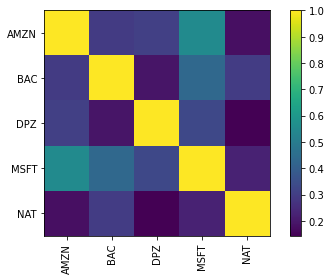

In [15]:
pfo.plotting.plot_covariance(S, plot_correlation=True);

In [16]:
# 目標リターン制約あり分散最小化
ef = pfo.efficient_frontier.EfficientFrontier(mu, S)
ef.efficient_return(target_return=0.1)

OrderedDict([('AMZN', 0.1399505450297059),
             ('BAC', 0.207520685721197),
             ('DPZ', 0.3380914360998427),
             ('MSFT', 0.2808263045723976),
             ('NAT', 0.0336110285768567)])

In [17]:
ef.portfolio_performance(verbose=True)

Expected annual return: 25.2%
Annual volatility: 20.3%
Sharpe Ratio: 1.14


(0.2517953813288073, 0.20308908088096797, 1.1413483202706713)

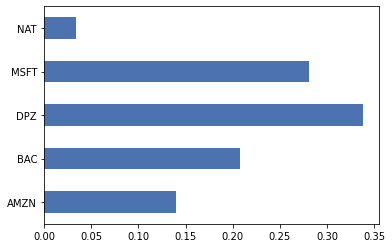

In [18]:
weights = ef.clean_weights()
pd.Series(weights).plot.barh();

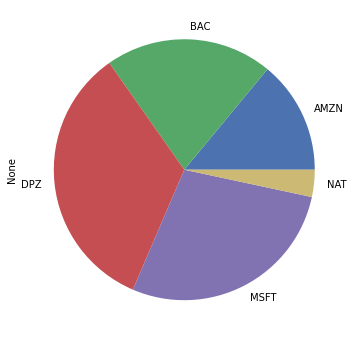

In [19]:
pd.Series(weights).plot.pie(figsize=(6, 6));

In [20]:
# 空売りを許す場合
ef = pfo.efficient_frontier.EfficientFrontier(
    expected_returns=mu,
    cov_matrix=S,
    weight_bounds=(-1, 1)  # 空売り制約を調整
)
ef.efficient_return(target_return=0.1)

OrderedDict([('AMZN', 0.1399505450297059),
             ('BAC', 0.207520685721197),
             ('DPZ', 0.3380914360998427),
             ('MSFT', 0.2808263045723976),
             ('NAT', 0.0336110285768567)])

In [21]:
# 最小分散ポートフォリオ
ef = pfo.efficient_frontier.EfficientFrontier(mu, S)
ef.min_volatility()

OrderedDict([('AMZN', 0.1399505450297059),
             ('BAC', 0.207520685721197),
             ('DPZ', 0.3380914360998427),
             ('MSFT', 0.2808263045723976),
             ('NAT', 0.0336110285768567)])

In [22]:
# シャープ・レシオ最大化
ef = pfo.efficient_frontier.EfficientFrontier(
    mu,
    S,
    weight_bounds=(0, 1)  # weight bounds
)
# 制約式を追加
ef.add_constraint(lambda w: w[0] <= 0.5)
ef.add_constraint(lambda w: w[1] >= 0.1)
ef.add_constraint(lambda w: w[2] + w[3] <= 0.5)
# L2正則化項を追加
ef.add_objective(pfo.objective_functions.L2_reg, gamma=1)

ef.max_sharpe(risk_free_rate=0.02)

/home/oga/.local/lib/python3.8/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.3323024718575019),
             ('BAC', 0.1676975281424983),
             ('DPZ', 0.2550461678050278),
             ('MSFT', 0.244953832194972),
             ('NAT', 0.0)])

In [23]:
# CVaR最適化
returns = pfo.expected_returns.returns_from_prices(df).dropna()
ec = pfo.efficient_frontier.EfficientCVaR(
    expected_returns=mu,
    returns=returns,
    beta=0.95,
    weight_bounds=(0, 1)
)
ec.efficient_return(target_return=0.1)

OrderedDict([('AMZN', 0.1072871191774033),
             ('BAC', 0.1929684464246123),
             ('DPZ', 0.3490393009394809),
             ('MSFT', 0.2930461124972256),
             ('NAT', 0.0576590209612778)])

In [24]:
ec.portfolio_performance(verbose=True)

Expected annual return: 24.2%
Conditional Value at Risk: 2.97%


(0.2423121523996347, 0.029665276783100804)

In [25]:
# CVaR最適化
returns = pfo.expected_returns.returns_from_prices(df).dropna()
ec = pfo.efficient_frontier.EfficientCVaR(
    expected_returns=mu,
    returns=returns,
    beta=0.95,
    weight_bounds=(0, 1)
)
ec.min_cvar()

OrderedDict([('AMZN', 0.1072871191781378),
             ('BAC', 0.1929684464251698),
             ('DPZ', 0.3490393009410182),
             ('MSFT', 0.2930461124952282),
             ('NAT', 0.057659020960446)])

### Discrete Allocation

https://pyportfolioopt.readthedocs.io/en/latest/Postprocessing.html

In [26]:
da = pfo.DiscreteAllocation(weights, df_prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $0.03


{'AMZN': 25, 'BAC': 129, 'DPZ': 17, 'MSFT': 22, 'NAT': 288}

### plot

https://pyportfolioopt.readthedocs.io/en/latest/Plotting.html

In [27]:
import copy

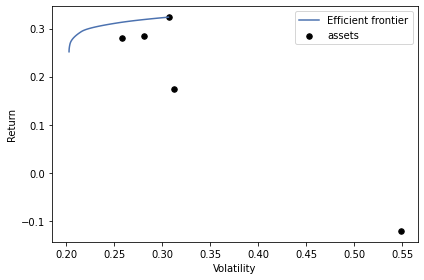

In [28]:
# 効率的フロンティアをプロット
ef = pfo.efficient_frontier.EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

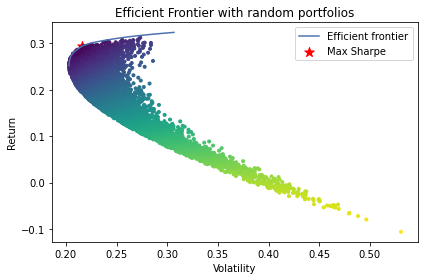

In [29]:
# 効率的フロンティアをプロット
ef = pfo.efficient_frontier.EfficientFrontier(mu, S)

fig, ax = plt.subplots()
ef_max_sharpe = copy.deepcopy(ef)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()